# Integrate and generate CITE-seq SLN Datasets from scRNA-seq SLN Datasets using experimental batches

The [SLN111](https://github.com/YosefLab/scVI-data/raw/master/sln_111.h5ad?raw=true) and [SLN208](https://github.com/YosefLab/scVI-data/raw/master/sln_208.h5ad?raw=true) CITE datasets was collected from Github. Ignore ADT measurements in the SLN208-D1, SLN208-D2, and SLN111-D2 dataset and use only scRNA-seq data.

In [1]:
import pandas as pd
import anndata
import numpy as np
import scanpy as sc

import scproca
from scproca.model import scProca

INFO     Last run with scProca version: 0.1                                                                        


## Set global parameters

In [2]:
scproca.settings.seed = 0
scproca.settings.batch_size = 512
scproca.settings.device = 0

INFO     Setting seed 0                                                                                            
INFO     Setting batch size 512                                                                                    
INFO     Using cuda 0 device                                                                                       


In [3]:
import seaborn as sns
import torch
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Load dataset from local source

In [4]:
dataset_SLN111 = anndata.read_h5ad("../../data/SLN/sln_111.h5ad")
dataset_SLN208 = anndata.read_h5ad("../../data/SLN/sln_208.h5ad")

## Standard data preprocessing

In [5]:
common_genes = dataset_SLN208.var_names.intersection(dataset_SLN111.var_names)
dataset_SLN208 = dataset_SLN208[:, common_genes]
dataset_SLN111 = dataset_SLN111[:, common_genes]
dataset_SLN208.obsm["protein_expression"] = pd.DataFrame(
    dataset_SLN208.obsm["protein_expression"],
    columns=dataset_SLN208.uns["protein_names"],
    index=dataset_SLN208.obs_names,
)
dataset_SLN111.obsm["protein_expression"] = pd.DataFrame(
    dataset_SLN111.obsm["protein_expression"],
    columns=dataset_SLN111.uns["protein_names"],
    index=dataset_SLN111.obs_names,
)
del dataset_SLN208.uns["protein_names"]
del dataset_SLN111.uns["protein_names"]

adata = anndata.concat([dataset_SLN208, dataset_SLN111], join="inner", index_unique='-')
adata.obs_names_make_unique()
adata.obsm["protein_expression"] = adata.obsm["protein_expression"].fillna(0)

/tmp/ipykernel_40633/2028401688.py:4: ImplicitModificationWarning: Setting element `.obsm['protein_expression']` of view, initializing view as actual.
  dataset_SLN208.obsm["protein_expression"] = pd.DataFrame(
/tmp/ipykernel_40633/2028401688.py:9: ImplicitModificationWarning: Setting element `.obsm['protein_expression']` of view, initializing view as actual.
  dataset_SLN111.obsm["protein_expression"] = pd.DataFrame(


## Adapt data for scProca

Ignore ADT measurements in the SLN111 dataset and use only scRNA-seq data.

In [6]:
adata = adata[np.random.permutation(adata.n_obs)].copy()
batch = adata.obs["batch"].values.ravel()

held_out_proteins = adata.obsm["protein_expression"][batch != "SLN111-D1"].copy()
adata.obsm["protein_expression"].loc[batch != "SLN111-D1"] = np.zeros(
    adata.obsm["protein_expression"][batch != "SLN111-D1"].shape
)
adata.obs["batch_general"] = adata.obs["batch"].map({
    "SLN208-D1" : "scRNA-seq (SLN208-D1)",
    "SLN208-D2" : "scRNA-seq (SLN208-D2)",
    "SLN111-D2" : "scRNA-seq (SLN111-D2)",
    "SLN111-D1" : "CITE-seq (SLN111-D1)",
})
valid_adt = np.array([True] * len(adata))
valid_adt[batch != "SLN111-D1"] = False
adata.obs["valid_adt"] = valid_adt

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True
)

In [7]:
adata

AnnData object with n_obs × n_vars = 32648 × 4000
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'batch_general', 'valid_adt'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'protein_expression'

## Initialize scProca model

In [8]:
scproca_model = scProca(
    adata=adata,
    key_adt="protein_expression",
    key_batch="batch",
    key_valid_adt="valid_adt"
    )

INFO     Computing empirical prior initialization for protein background.                                          


## Train scProca model

/data/data2/xionglab/anaconda3/envs/scMuMA/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Training Progress: 100%|██████████████████| 400/400 [20:22<00:00,  3.06s/it, loss_discriminator=4.14, loss_elbo=2.14e+3]


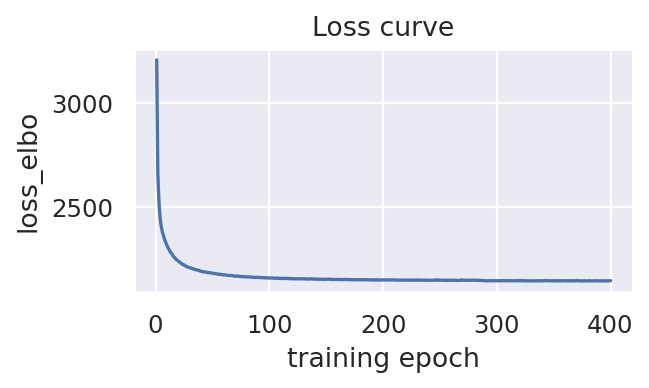

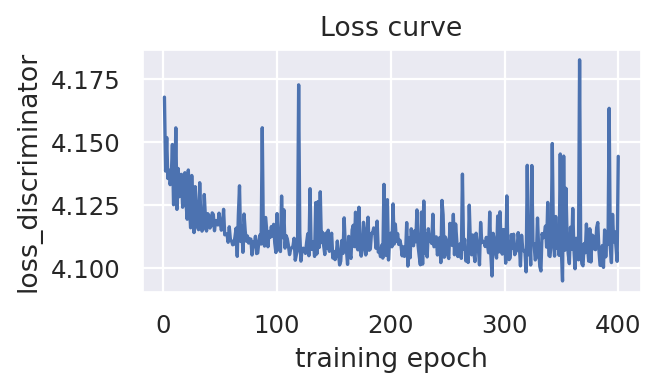

In [9]:
scproca_model.train()
scproca_model.curve_loss(key_loss="loss_elbo")
scproca_model.curve_loss(key_loss="loss_discriminator")

## Infer the integrated latent representation, RNA-specific embedding, and ADT-specific embedding for each cell

In [10]:
adata.obsm["latent"], adata.obsm["embedding_rna"], adata.obsm["embedding_adt"] = scproca_model.get_latent_representation()

Inference Progress: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


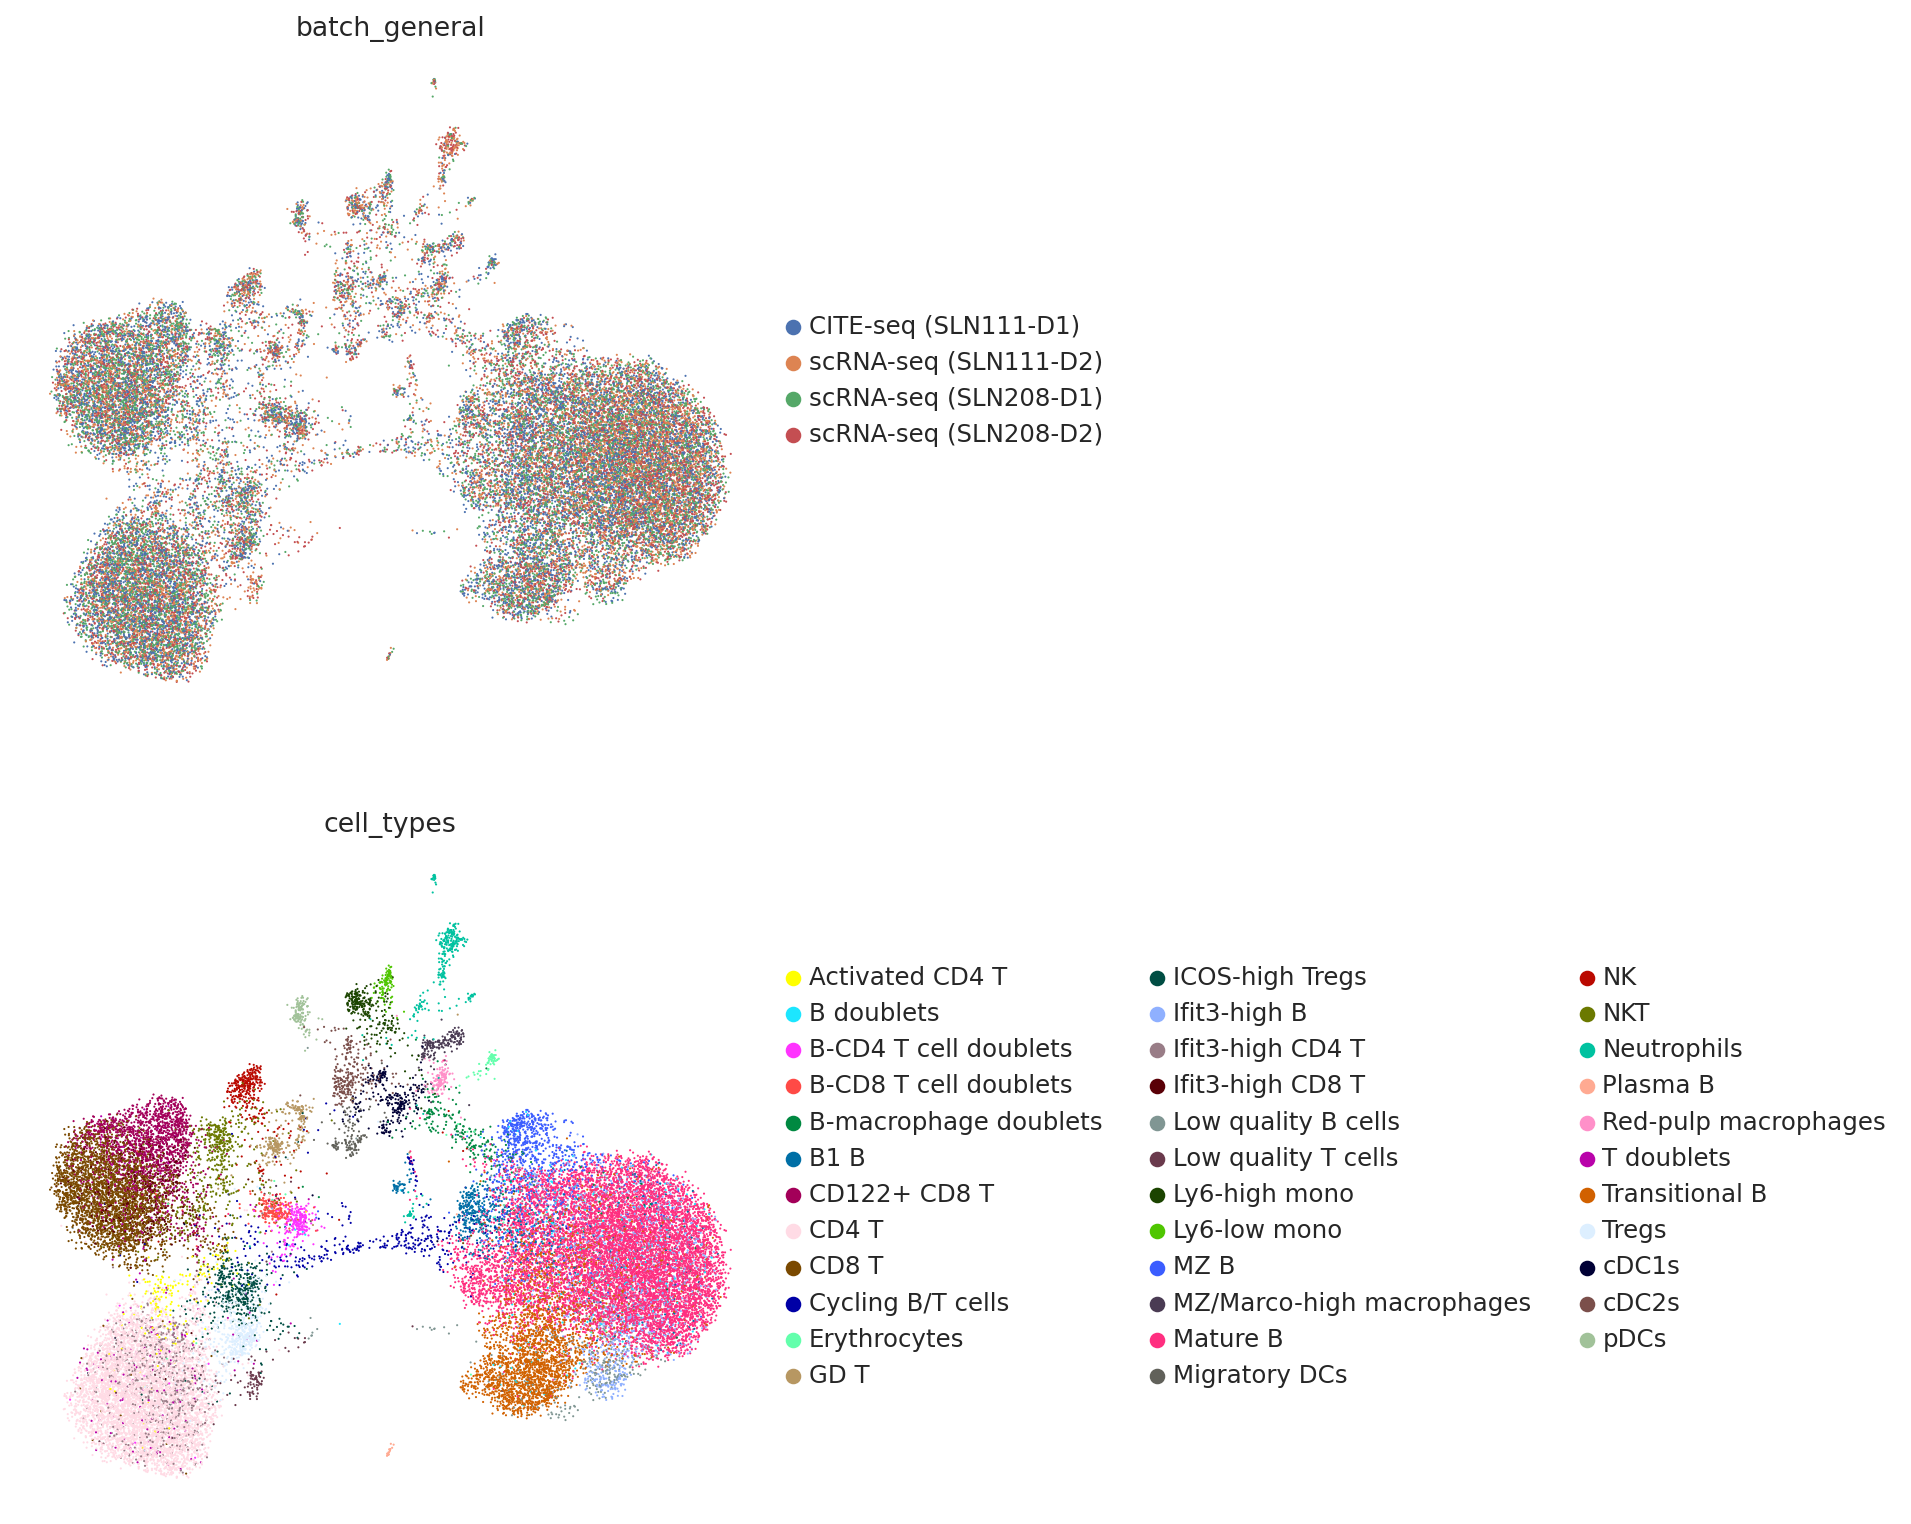

In [11]:
import matplotlib.pyplot as plt
sc.pp.neighbors(adata, use_rep="embedding_rna")
sc.tl.umap(adata)
_, axes = plt.subplots(2, 1, figsize=(6, 12))
sc.pl.umap(
    adata,
    color="batch_general",
    frameon=False,
    ax=axes[0],
    show=False
)
sc.pl.umap(
    adata,
    color="cell_types",
    frameon=False,
    ax=axes[1],
    show=False
)
plt.show()

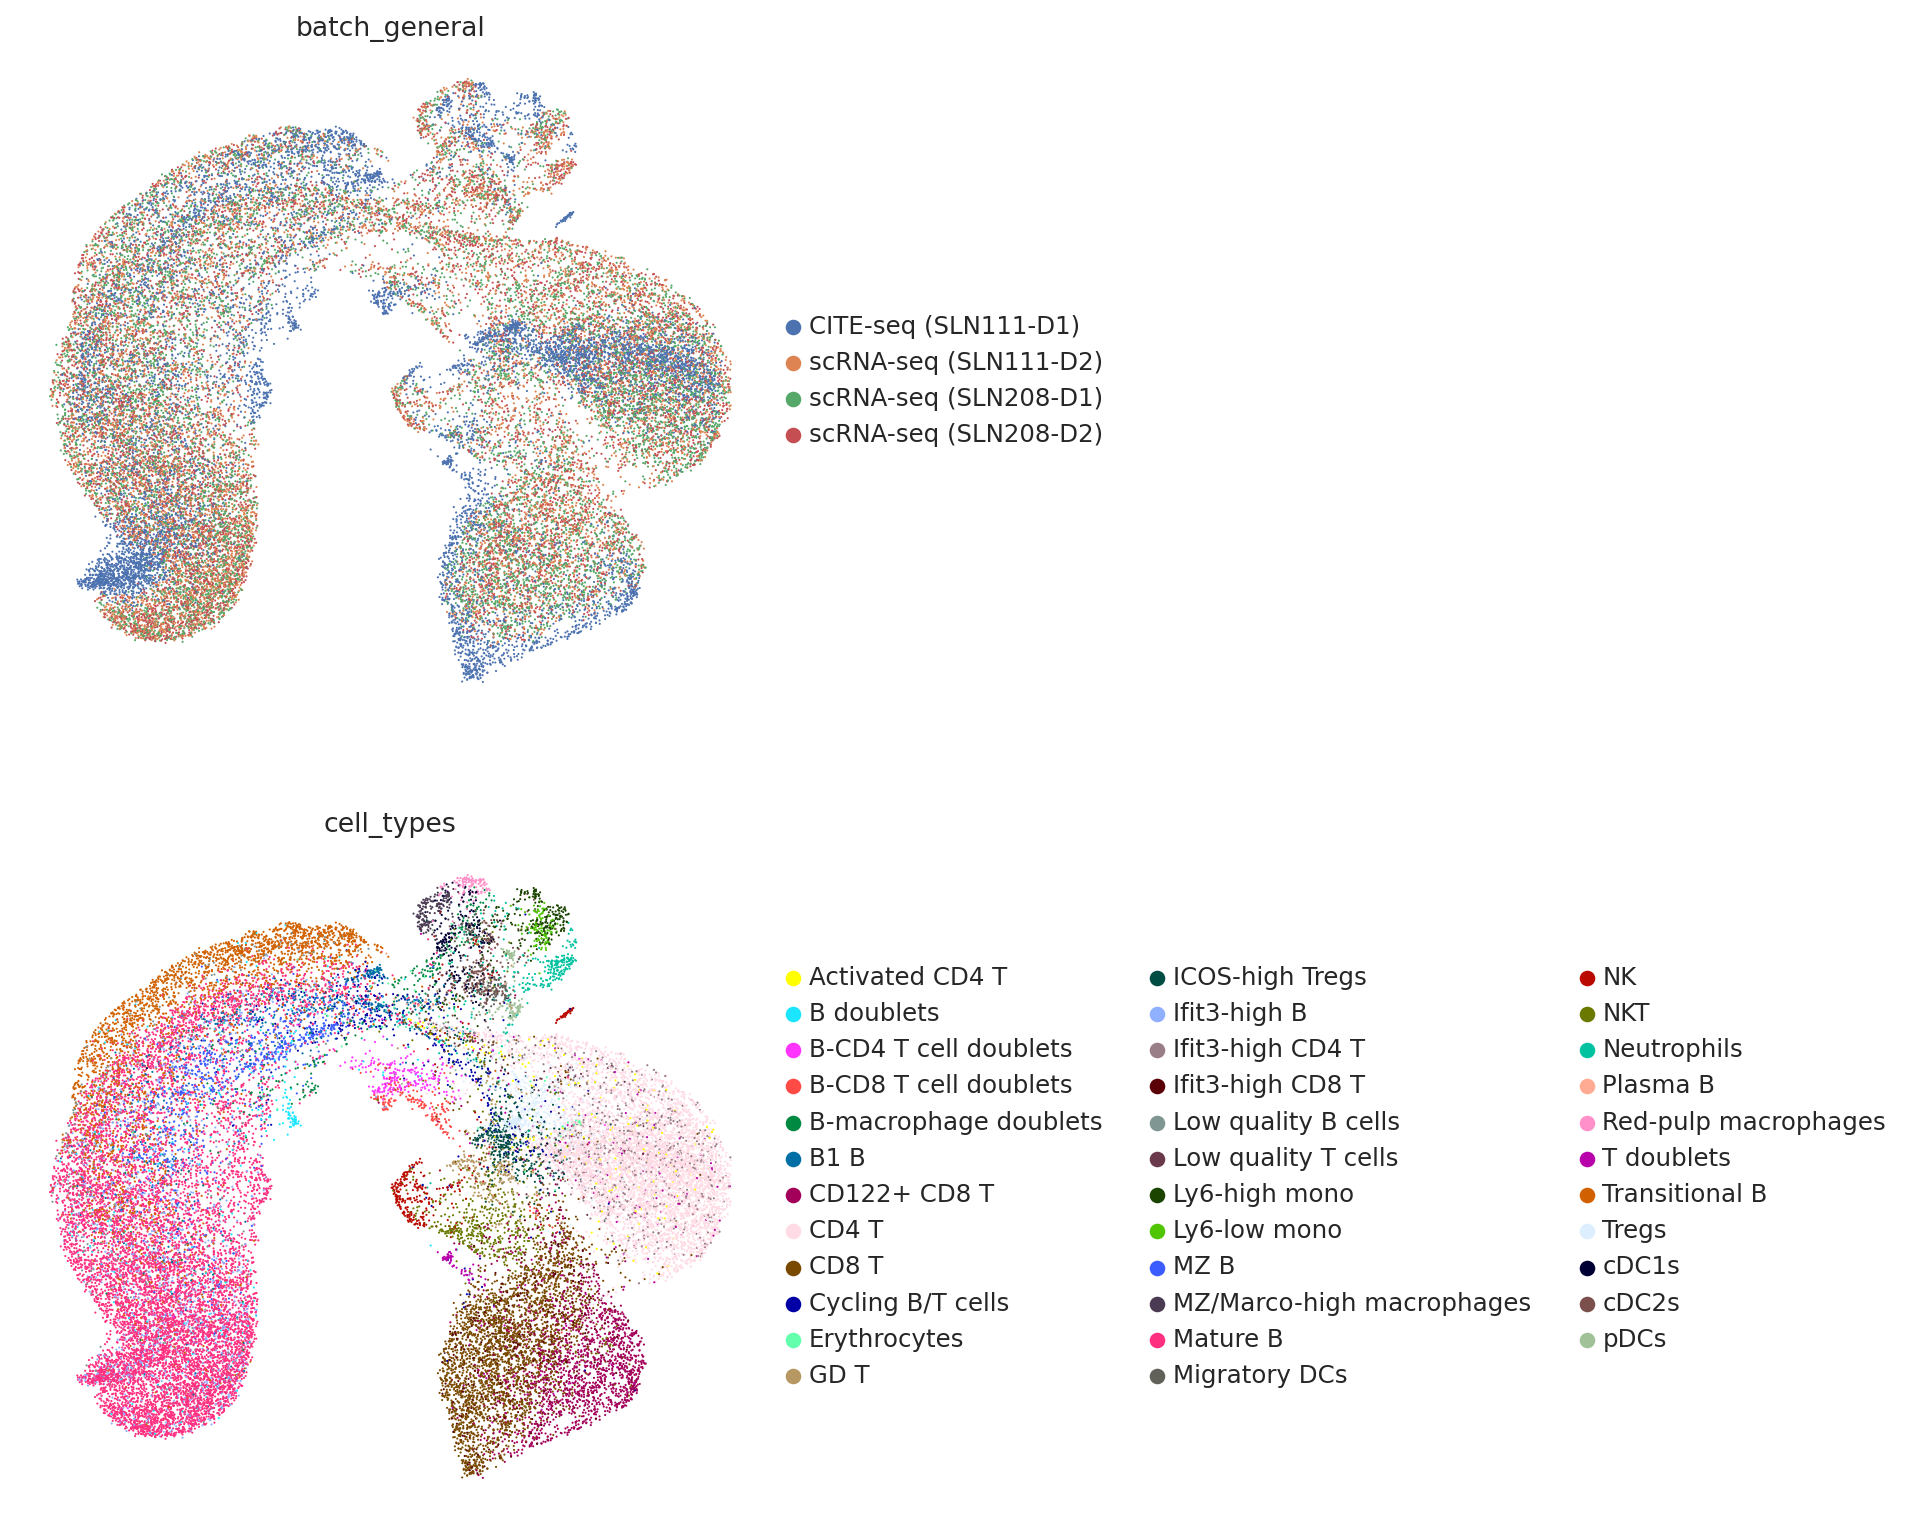

In [12]:
sc.pp.neighbors(adata, use_rep="embedding_adt")
sc.tl.umap(adata)
_, axes = plt.subplots(2, 1, figsize=(6, 12))
sc.pl.umap(
    adata,
    color="batch_general",
    frameon=False,
    ax=axes[0],
    show=False
)
sc.pl.umap(
    adata,
    color="cell_types",
    frameon=False,
    ax=axes[1],
    show=False
)
plt.show()

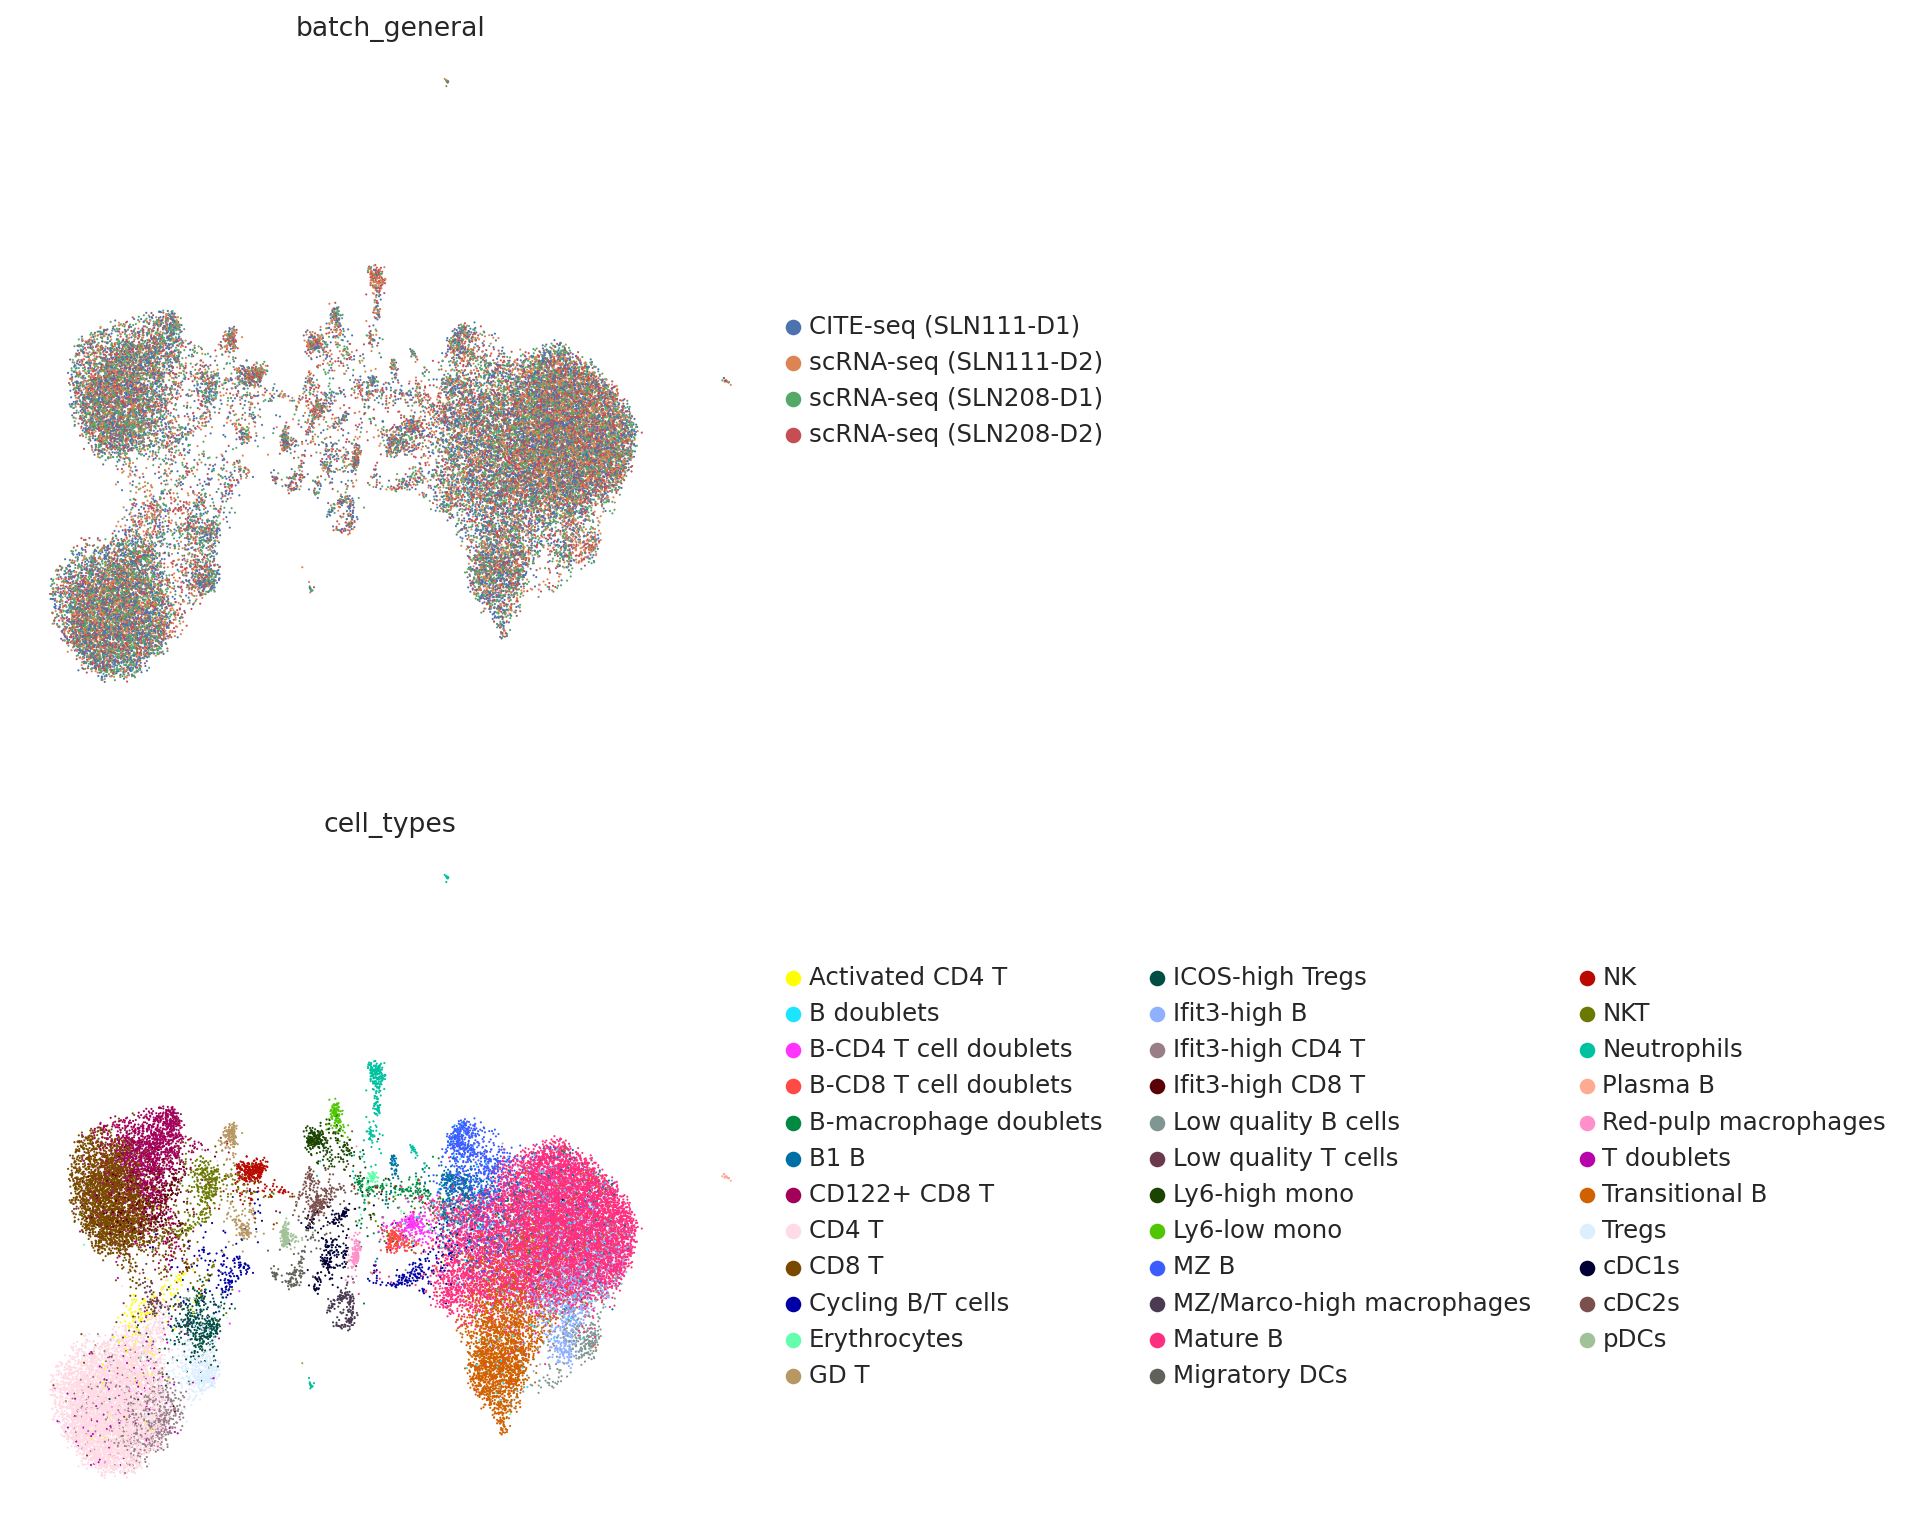

In [13]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)
_, axes = plt.subplots(2, 1, figsize=(6, 12))
sc.pl.umap(
    adata,
    color="batch_general",
    frameon=False,
    ax=axes[0],
    show=False
)
sc.pl.umap(
    adata,
    color="cell_types",
    frameon=False,
    ax=axes[1],
    show=False
)
plt.show()

## Generate ADT measurements for each cell

In [14]:
protein_generation = scproca_model.generation(anchor_batch="SLN111-D1")
protein_observed = adata.obsm["protein_expression"].values.copy()
protein_observed[batch != "SLN111-D1"] = held_out_proteins.values

# cleaner protein names
parsed_protein_names = [
    p.split("_")[0] for p in adata.obsm["protein_expression"].columns
]
for i, p in enumerate(parsed_protein_names):
    adata.obs[f"{p} imputed"] = protein_generation[:, i]
    adata.obs[f"{p} observed"] = protein_observed[:, i]

Inference Progress: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


In [15]:
# viz_keys = []
# for p in parsed_protein_names:
#     viz_keys.append(p + " imputed")
#     viz_keys.append(p + " observed")
# 
# sc.pl.umap(
#     adata[batch != "SLN111-D1"],
#     color=viz_keys,
#     ncols=2,
#     vmax="p99",
#     frameon=False,
#     add_outline=True,
#     wspace=0.1,
# )